# Viva la Convolution!

Convolution is a basic mathematical operation -- in a very real way, it's only slightly less fundamental than addition and multiplication! Because of its fundamental nature, convolution arises repeatedly in both theoretical and applied contexts.

This notebook focuses on offering examples of applications of convolution, in particular to signal processing and neuroscience. If you want to learn more about the theory of convolutions, check out [this blog post by Chris Olah](http://colah.github.io/posts/2014-12-Groups-Convolution/) or the [other notebook in this folder](What's%20a%20Convolution%3F.ipynb).

### Preliminaries

In [1]:
from __future__ import division

import matplotlib
matplotlib.use("TkAgg")
%pylab inline
plt.xkcd();

from scipy.stats import multivariate_normal

from scipy.io import wavfile
from IPython.display import Audio

import scipy.signal
from PIL import Image

import plotFunks as pF

Populating the interactive namespace from numpy and matplotlib


In [2]:
def kernelsPlot(kernels,kernelNames):
    plt.figure(figsize=(16,4)); numKernels= len(kernels)
    for idx,(kernel,kernelName) in enumerate(zip(kernels,kernelNames)):
        plt.subplot(1,numKernels,idx+1)
        plotKernel(kernel)
        plt.title(kernelName)
        plt.ylim(-1,1.5); plt.xlim(-len(kernel)/10,len(kernel)+len(kernel)/10); 
        pF.cleanPlot(plt.gca()); pF.addAxis(plt.gca(),'horizontal')


def plotKernel(kernel):
    plt.scatter(np.arange(0,len(kernel)),kernel,
                linewidth=0,marker='o',s=36,color='r',
                zorder=10); 
    plt.vlines(np.arange(0,len(kernel)),0,kernel,)

# Convolution on Audio Files

The following code blocks load an audio file, define some convolutions, and then apply those convolutions to the audio file. If you have a .wav file lying around on your computer, just change the `filename` in the first line of code below.

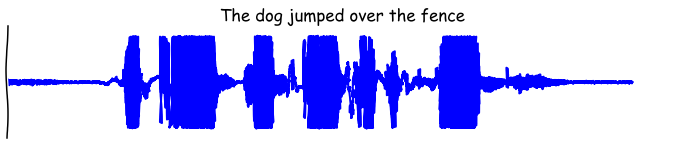

In [3]:
filename = 'Kira_Training1.wav' #your wavfile here!

samplerate,waveform = wavfile.read(filename) 
plt.figure(figsize=(12,2))
plt.plot(waveform); pF.cleanPlot(plt.gca()); 
plt.title("The dog jumped over the fence");
Audio('Kira_Training1.wav')

We define convolutions using something called a "kernel". A kernel represents the output for a single data point with the value 1, presented at time 0. We get the total output for a signal with many points at different times and with different values by adding together the kernel responses to each point. These responses are scaled by the value of the signal at that datapoint and shifted by how far into the signal the datapoint it.

The "echo" kernel is easy to interpret in these terms -- when you put in a single point, it first responds by spitting that point back out, then waits a few seconds, and spits the point back out again. If you do this for all of the points in your audio signal, you get out two copies of the signal layered on top each other, with one of them delayed in time. Sounds like an echo to me!

If this is confusing for you, check out the [other notebook in this folder](What's%20a%20Convolution%3F.ipynb) if you want a walkthrough.

Two of the convolutions act as frequency filters -- they remove either the low-frequency components (letting the high frequencies pass) or the high frequency components (letting the low frequencies pass). Discovering this from their kernels is kinda hard. (Optional section ahead!) If you know about [Fourier transforms](http://www.neurotheory.columbia.edu/Ken/math-notes/math-notes-4.pdf) and the [convolution theorem](https://www.youtube.com/watch?v=a0IdGLczoAA), then try Fourier transforming them and looking at the frequency plots. If you don't want to do the Fourier transform yourself, you can look up the Fourier transform of the boxcar function.

If you don't, you can think of them as the "difference" and "moving average" kernels instead. Can you see why that might be the case from their kernels? 

In [4]:
# Define Our Kernels
pad = 5; padding = [0]*pad
difference = padding+[-1/2,0,1/2]+padding;
average = padding+[1/3,1/3,1/3]+padding
                      
echoTime = 0.25
echoGapLength=samplerate*echoTime
echo = padding+[1]+[0]*int(echoGapLength)+[1]+padding

kernels = [difference,average,echo]
kernelNames = ['high-pass/difference','low-pass/moving average','echo']
numKernels = len(kernels)

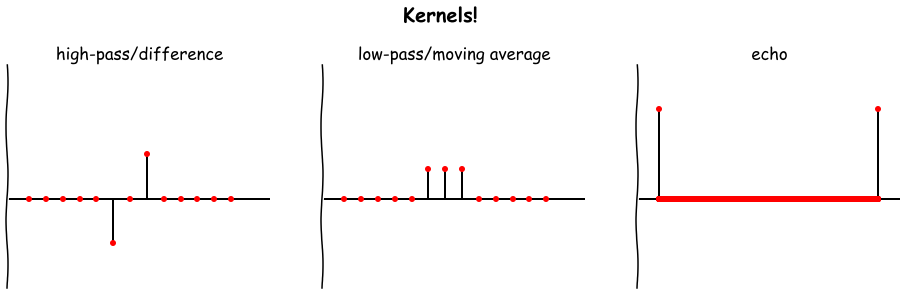

In [5]:
# Plot Our Kernels  
kernelsPlot(kernels,kernelNames)
plt.suptitle('Kernels!',fontsize=20,weight='bold',y=1.1);

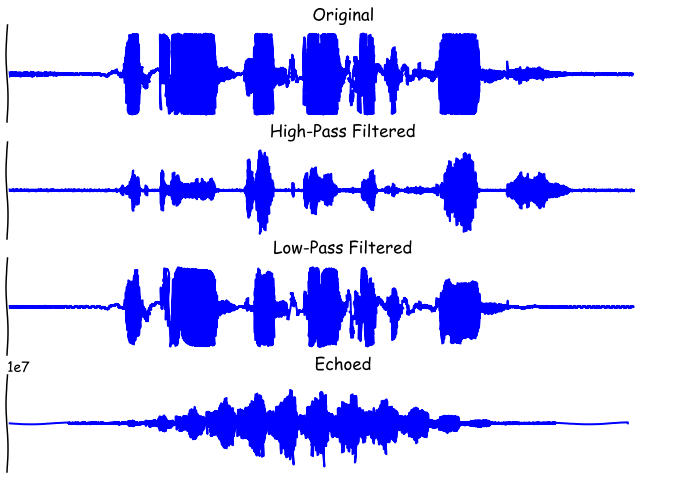

In [6]:
signals = [waveform]*(numKernels+1)
signalNames = ['Original','High-Pass Filtered','Low-Pass Filtered','Echoed']

# Convolve Signals With Kernels n times
n = 10
for idx,kernel in enumerate(kernels):
    for _ in range(n):
        signals[idx+1] = np.convolve(signals[idx+1],kernel)

    
# Plot those bad boys
plt.figure(figsize(12,2*(numKernels+1))); 
ct = 1

for signal,title in zip(signals,signalNames):
    plt.subplot(len(signals),1,ct); ct +=1
    plt.plot(signal); pF.cleanPlot(plt.gca())
    plt.title(title)

The next cell lets you listen to the results, instead of just looking at them. Just change the `idx` variable. If any of the signals won't play, try reducing the `n` variable in the cell above.

In [7]:
# Listen to each signal by indexing into signals with idx below
# 0 for the original, 1 for the high-pass filtered one, etc.
idx = 2
Audio(signals[idx],rate=samplerate)

## Convolution on Images

We can also apply convolutions in more than one dimension. In two dimensions, we can view the results as images. Not only that, but we can use convolutions on images to get new images or to extract useful information.

Again, you can change the input signal to whatever you want in the cell below by just changing the `filename`.

In [8]:
filename = 'burtreynolds.jpg' #your image here!

im = Image.open(filename);
im = im.convert('L'); im = numpy.asarray(im)

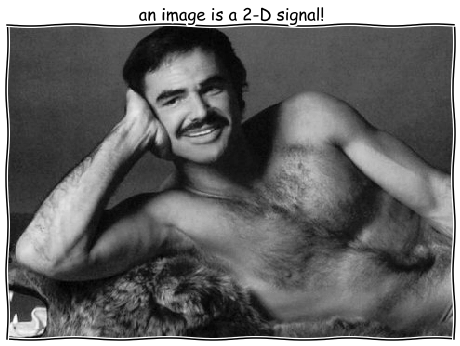

In [9]:
plt.figure(figsize=(8,8))
plt.imshow(im,cmap='Greys_r',interpolation='none'); pF.removeAxes(plt.gca())
plt.title('an image is a 2-D signal!');

For the audio signal, we were mostly interested in using convolution to generate new audio signals. Let's use a convolution to extract some information from our image, namely: where are the edges?

We do this by defining kernels that look like tiny edges, then sliding them over our image. At each point, we plot the output of our kernel. This is just another way of describing the same operation we were performing above, where we made scaled copies of the kernel and added them together.

One important difference is that the kernels we've defined will be mostly 0 or close to 0, and will only be large in places where an edge of the right orientation is present. This makes them "edge detectors". Before, our kernels were usually close to the value of the input signal, so they weren't very good detectors of anything.

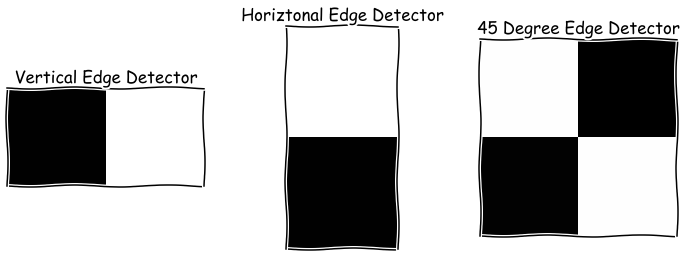

In [10]:
#Define some edge-detecting image kernels
i=1
vEdgeDetection = [[-i,i],];

hEdgeDetection = [[i],
                  [-i]]

diagEdgeDetection =  [[1/4,    -1/4],
                      [-1/4,   1/4]]

kernels = [vEdgeDetection,hEdgeDetection,diagEdgeDetection]
kernelNames = ["Vertical Edge Detector","Horiztonal Edge Detector","45 Degree Edge Detector"]
numKernels = len(kernels)

signals = [im]
signalNames = ["Original","Vertical Edges","Horiztonal Edges","45 Degree Edges"]

plt.figure(figsize(12,4));

for idx,(kernel,name) in enumerate(zip(kernels,kernelNames)):
    signals.append(np.abs(scipy.signal.convolve2d(signals[0],kernel)))
    plt.subplot(1,numKernels,idx+1); plt.title(name)
    plt.imshow(kernel,interpolation='none',cmap="Greys_r"); pF.removeAxes(plt.gca())

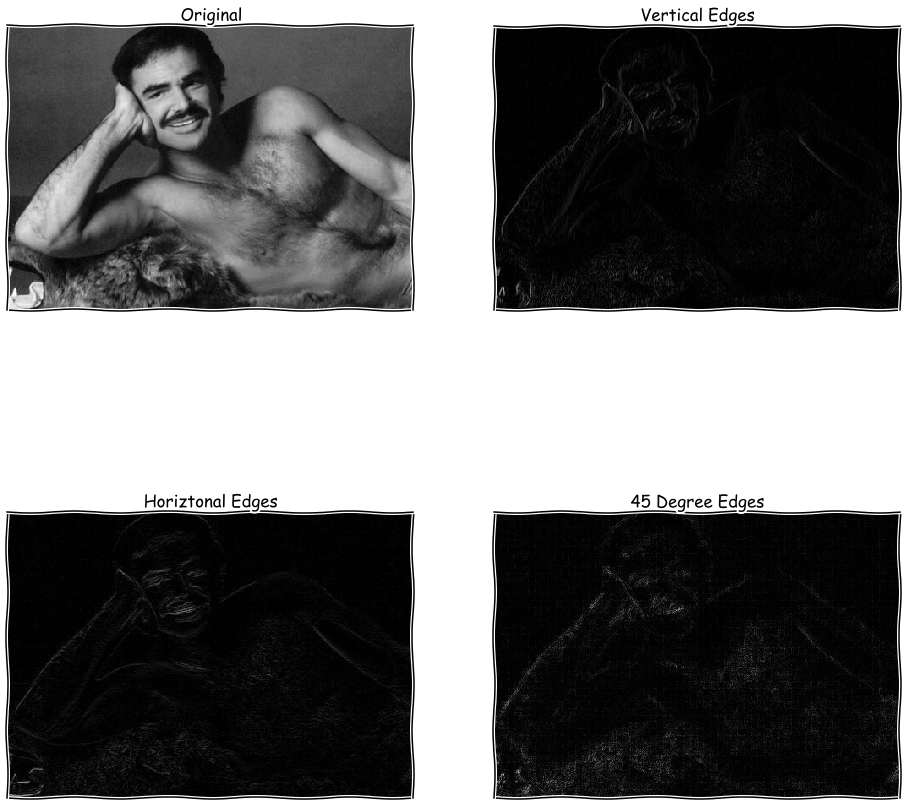

In [11]:
plt.figure(figsize=(16,16)); numSignals = len(signals)
cmaps = ['Greys_r','binary_r','binary_r','binary_r'];

for idx,(signal,name) in enumerate(zip(signals,signalNames)):
    plt.subplot(2,numSignals//2,idx+1); plt.title(name)
    plt.imshow(signal,cmap=cmaps[idx],interpolation='none'); pF.removeAxes(plt.gca())

#Convolution and Neuroscience

Taking signals in and extracting information from them is one of the primary functions of the nervous system, so it should come as no surprise that convolutions appear as models for neural activity.

Of course, convolutions are pretty restricted, as far as signal transformations go (for mathy types, they are *linear* and *invariant to translations*), and we know neurons are capable of some pretty complicated transformations -- like extracting the spoken words from an audio stream, or turning an image into a series of ideas (like you're doing now!).

We can make our convolutions more complicated if we allow some kind of non-convolutional transformation afterwards (for mathletes -- a *non-linear* transformation). One example might be the transformation between the total input to a neuron to its firing rate. A very simple model would say that when input is below a threshold value, firing rate is 0, and then firing rate rises linearly as input increases above that value (this is the response function of a [leaky integrator neuron](http://charlesfrye.github.io/FoundationalNeuroscience/25/)). The graph (which appears below) looks a bit like a hockey stick.

So our simple neurons act as follows: they are a linear filter of some part of the visual field, and they take their output and push it through a non-linearity. If we have a whole bunch of them with the same filter, but scattered over the input space, then they define a convolution with that filter as a kernel, plus a non-linearity at the end.

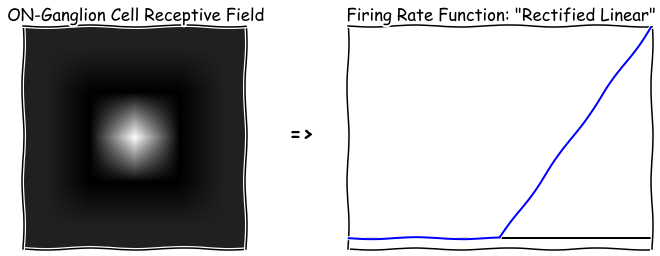

In [12]:
def makeCenterSurround(N):
    n = N//8
    return [[0,0,0,0,0],[0,-n,-n,-n,0],[0,-n,N,-n,0],[0,-n,-n,-n,0],[0,0,0,0,0]]

intensities = [8] # ACHTUNG!: should be == 0 mod 8
kernels = []

for intensity in intensities:
    kernels.append(makeCenterSurround(intensity))

kernels.append(np.multiply(kernels[0],-1))

plt.figure(); plt.subplot(1,2,1)
plt.imshow(kernels[0],cmap='Greys_r'); pF.removeAxes(plt.gca()); 
plt.title('ON-Ganglion Cell Receptive Field');
plt.figtext(0.48,0.5,'=>',size='x-large',weight='bold')
plt.subplot(1,2,2)
plt.plot(range(-10,11),np.multiply(list(range(-10,11)),np.asarray([[0]*11+[1]*10])).T,zorder=10)
plt.xlim([-10,10]); plt.ylim([-0.5,10])
pF.removeAxes(plt.gca())
pF.addAxis(plt.gca(),'horizontal');
plt.title('Firing Rate Function: "Rectified Linear"');

If you've ever worked with real neurons, you're probably screaming right now that *real neurons* are way more complicated than that! As true as that is, it turns out you can get a lot of mileage out of this simple model. For one, it's a first step at [explaining perceptual invariance](http://charlesfrye.github.io/FoundationalNeuroscience/09/). For another, it's the core of the idea of a [convolutional neural network](http://colah.github.io/posts/2014-07-Conv-Nets-Modular/), which happens to be our current best technique for extracting information from images. It is also a major component of the algorithm that Google used to beat the world champion at the ancient game of Go!

In the code blocks below, I generate an example model based on one of the best-studied neural-populations the ON- and OFF-center ganglion cells of the retina. Check out [this blog post by yrs truly](http://charlesfrye.github.io/FoundationalNeuroscience/50/) for more on this circuit, including the biological and information-theoretic underpinnings of the receptive field shape.

The resulting image doesn't seem that impressive, but it has [far fewer active neurons](http://charlesfrye.github.io/FoundationalNeuroscience/48/) and has [less redundant information](http://charlesfrye.github.io/FoundationalNeuroscience/51/) than a naïve code -- useful properties for a nervous system that has limited energy and space.

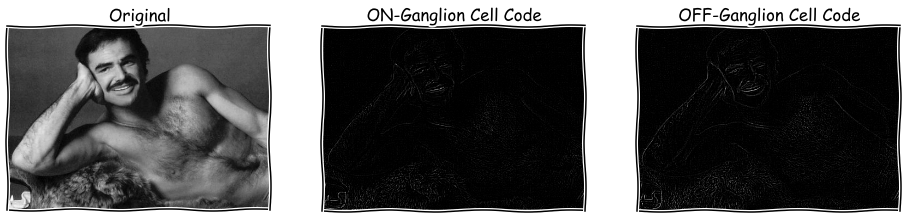

In [13]:
signals = [im]
signalNames = ["Original","ON-Ganglion Cell Code","OFF-Ganglion Cell Code"]

for idx,kernel in enumerate(kernels):
    signals.append(scipy.signal.convolve2d(signals[0],kernel))
    signals[-1] = np.multiply(signals[-1],np.greater(signals[-1],0))

numSignals = len(signals)
#numPlots = numSignals+1

plt.figure(figsize=(16,8));
for idx,(signal,name) in enumerate(zip(signals,signalNames)):
    plt.subplot(1,numSignals,idx+1); plt.title(name)
    plt.imshow(signal,cmap='Greys_r'); pF.removeAxes(plt.gca())